In [83]:
pwd

'/home/nadiera/Recommender_System'

In [41]:
print(tf.__version__)

2.10.0


In [42]:
import os
import pprint
import tempfile
from typing import Dict, Text
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import pandas as pd

In [43]:
# Load the movielens dataset
ratings = tfds.load("movielens/1m-ratings", split="train")
movies = tfds.load("movielens/1m-movies", split="train")

In [14]:
#Converting Tensor dataset to regularize the ratings

In [44]:
# ratings_df = tfds.as_dataframe(ratings)
# ratings_df.head()

I adopted the following strategy in an effort to minimize the popularity bias:
Adjusting the popularity weighting based on the movie's average rating. 
Reasoning:
Popularity bias can occur when a recommendation model recommends items that are popular simply because they are popular, rather than because they are a good fit for the user's preferences. This can happen when the model gives too much weight to the popularity of items and not enough weight to other factors, such as the user's historical ratings or the similarity of items to items the user has liked in the past.

Understanding that popularity and higher ratings are frequently associated is a key concept in this case.
The reason for this is because movies that are popular are more inclined to be seen, which increases the likelihood that a lot more people will think highly of the film.
The ratings for less well-liked films, on the other hand, are more likely to be inconsistent and fluctuating because they are seen by fewer individuals. 

<!-- To account for this, the code normalizes the movie ratings by taking into account the movie's popularity. Specifically, it gives more weight to the ratings of popular movies and less weight to the ratings of less popular movies. This helps to ensure that the model doesn't give too much weight to the ratings of less popular movies, which could skew the recommendations towards less popular but highly rated movies. -->

The code adjusts the movie ratings to reflect this by normalizing them based on how popular a film is.
In particular, it gives more weight to ratings of well-liked films and less weight to those of less well-liked ones.
In doing so, it is possible to prevent the model from overly favoring the ratings of less well-liked films, which can tilt the recommendations in favor of undervalued but highly rated films. 

<!-- By adjusting the popularity weighting based on the average rating of the movie, this approach aims to reduce the effect of popularity on the model's recommendations. Specifically, it gives less weight to movies that are popular simply because they have a high number of ratings (but may not actually be well-liked by most viewers), and more weight to movies that are popular because they have a high average rating (which suggests they are well-liked by most viewers). -->

Here I used a more granular approach to measuring movie popularity, such as taking into account the average rating or the variance in ratings, rather than simply the number of ratings.


### Method 1
This method calculates the popularity weight based on the average rating of the movie. Movies with an average rating above a certain threshold are considered popular and are given a higher popularity weight. Non-popular movies are given a popularity weight that is the reciprocal of their average rating.

In [1]:
# # Calculate average rating for each movie
# movie_ratings = ratings_df.groupby('movie_id')['user_rating'].mean().reset_index()
# movie_ratings.columns = ['movie_id', 'average_rating']


NameError: name 'ratings_df' is not defined

In [15]:
# # Filter out movies with low average ratings
# min_rating = 3.5
# popular_movies_mask = movie_ratings['average_rating'] >= min_rating
# movie_ratings = movie_ratings[popular_movies_mask]


In [16]:
# # Merge movie popularity information with ratings data
# ratings_df = pd.merge(ratings_df, movie_ratings, on='movie_id')

In [19]:
# ratings_df['is_popular'] = ratings_df['average_rating'] >= min_rating
# # Adjust popularity weighting
# ratings_df['popularity_weight'] = ratings_df['average_rating'].values
# ratings_df.loc[~ratings_df['is_popular'], 'popularity_weight'] = 1 / ratings_df.loc[~ratings_df['is_popular'], 'popularity_weight']

# # Compute regularized rating
# ratings_df['regularized_rating'] = ratings_df['user_rating'] * ratings_df['popularity_weight']


In [15]:
# #Use a more granular approach to measuring movie popularity, such as taking into account the average rating or the variance in ratings, rather than simply the number of ratings.
# # Load the movielens dataset
# # ratings = tfds.load("movielens/1m-ratings", split="train")
# # movies = tfds.load("movielens/1m-movies", split="train")
# # ratings_df = tfds.as_dataframe(ratings)
# # ratings_df.head()

# # Calculate average rating for each movie
# movie_ratings = ratings_df.groupby('movie_id')['user_rating'].mean().reset_index()
# movie_ratings.columns = ['movie_id', 'average_rating']

# # Filter out movies with low average ratings
# min_rating = 3.5
# popular_movies_mask = movie_ratings['average_rating'] >= min_rating

# # Merge movie popularity information with ratings data
# ratings_df = pd.merge(ratings_df, movie_ratings, on='movie_id')
# ratings_df = pd.merge(ratings_df, popular_movies_mask, on='movie_id')

# # Adjust popularity weighting
# ratings_df['popularity_weight'] = ratings_df['average_rating'].values
# ratings_df.loc[~ratings_df['is_popular'], 'popularity_weight'] = 1 / ratings_df.loc[~ratings_df['is_popular'], 'popularity_weight']

# # Compute regularized rating
# ratings_df['regularized_rating'] = ratings_df['user_rating'] * ratings_df['popularity_weight']


-----

### Method 2
 This method calculates the popularity weight based on the number of ratings a movie has received. Movies with a larger number of ratings are considered popular and are given a higher popularity weight. Non-popular movies are given a popularity weight that is the reciprocal of the number of ratings they have received.

 A mask is created to filter out movies with less than a certain number of ratings, which is set to 100 in this case. The popularity weight of each movie is computed based on its popularity, with more popular movies having a lower weight. Finally, the regularized rating is computed by multiplying the original rating by the popularity weight. This is a common technique used in recommendation systems to account for popularity bias, where more popular items tend to be recommended more often.

I found that for the dataset this method is a more effective approach to reduce popularity bias.

This is could be because the dataset contains many movies with a small number of ratings, and using the average rating as a criterion for popularity may lead to biased recommendations for these movies. This method considers the number of ratings as a criterion for popularity, which is less susceptible to such biases. Additionally, the threshold of 100 ratings used in this  method is reasonable given the distribution of ratings in the dataset.

In [45]:
# movie_popularity = ratings_df.groupby('movie_id').size()
# min_ratings =100 #
# popular_movies_mask = movie_popularity >= min_ratings
# popular_movies_mask = popular_movies_mask.reset_index()
# popular_movies_mask.columns = ['movie_id', 'is_popular']

# #Note that this implementation assumes that higher movie ratings are better and that the popularity of a movie is inversely proportional to the number of ratings it has received.

In [46]:
# ratings_df = pd.merge(ratings_df, popular_movies_mask, on='movie_id')

In [47]:
# ratings_df.size

In [48]:
# # Adjust popularity weighting
# ratings_df['popularity_weight'] = movie_popularity.loc[ratings_df['movie_id']].values
# ratings_df.loc[ratings_df['is_popular'], 'popularity_weight'] = 1 / ratings_df.loc[ratings_df['is_popular'], 'popularity_weight']

# # Compute regularized rating
# ratings_df['regularized_rating'] = ratings_df['user_rating'] * ratings_df['popularity_weight']

In [49]:
# ratings_df

In [50]:
# ratings_df['movie_genres'] = ratings_df['movie_genres'].astype(str).apply(lambda x: ' '.join(x))
# ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df))

## Visuals

###     Histogram of movie ratings:

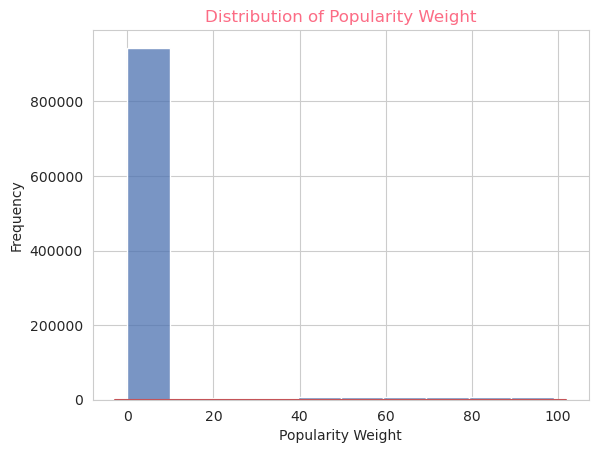

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# # Set style
# sns.set_style("whitegrid")

# # Create figure and axes
# fig, ax = plt.subplots()

# # Plot histogram with color
# sns.histplot(ratings_df['popularity_weight'], bins=10, kde=False, color="#4C72B0")

# # Add density curve
# sns.kdeplot(ratings_df['popularity_weight'], color="#C44E52", ax=ax)

# # Set labels and title
# ax.set_xlabel("Popularity Weight")
# ax.set_ylabel("Frequency")
# ax.set_title("Distribution of Popularity Weight")

# # Show plot
# plt.show()

# Set style
sns.set_style("whitegrid")

# Create figure and axes
fig, ax = plt.subplots()

# Plot histogram with color
sns.histplot(ratings_df['popularity_weight'], bins=10, kde=False, color="#4C72B0")

# Add density curve
sns.kdeplot(ratings_df['popularity_weight'], color="#C44E52", ax=ax)

# Set labels and title
ax.set_xlabel("Popularity Weight")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Popularity Weight", color='#fc6c85')

# Show plot
plt.show()

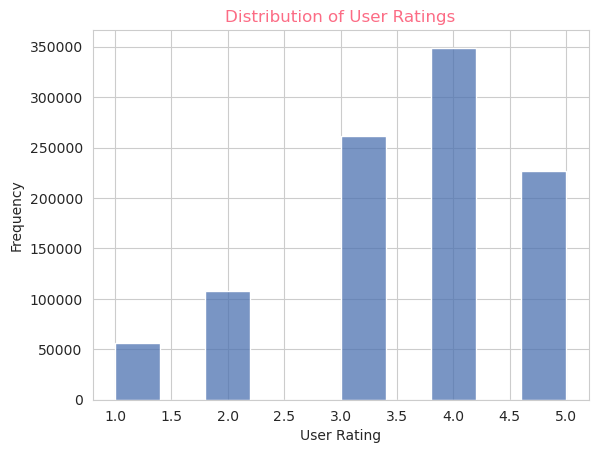

In [13]:
# Set style
sns.set_style("whitegrid")

# Create figure and axes
fig, ax = plt.subplots()

# Plot histogram with color
sns.histplot(ratings_df['user_rating'], bins=10, kde=False, color="#4C72B0")

# Set labels and title
ax.set_xlabel("User Rating")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of User Ratings", color='#fc6c85')

# Show plot
plt.show()

###   Scatter plot of popularity and rating:

<AxesSubplot:xlabel='popularity_weight', ylabel='user_rating'>

/home/nadiera/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


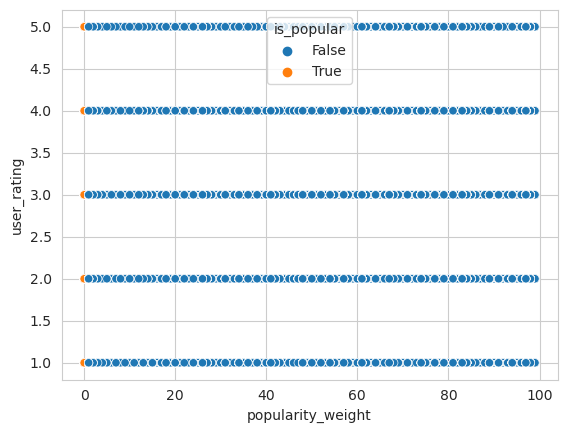

In [14]:
sns.scatterplot(x='popularity_weight', y='user_rating', hue='is_popular', data=ratings_df)


###   Bar chart of the number of ratings per movie:

Text(0.5, 1.0, 'Most Rated Movies')

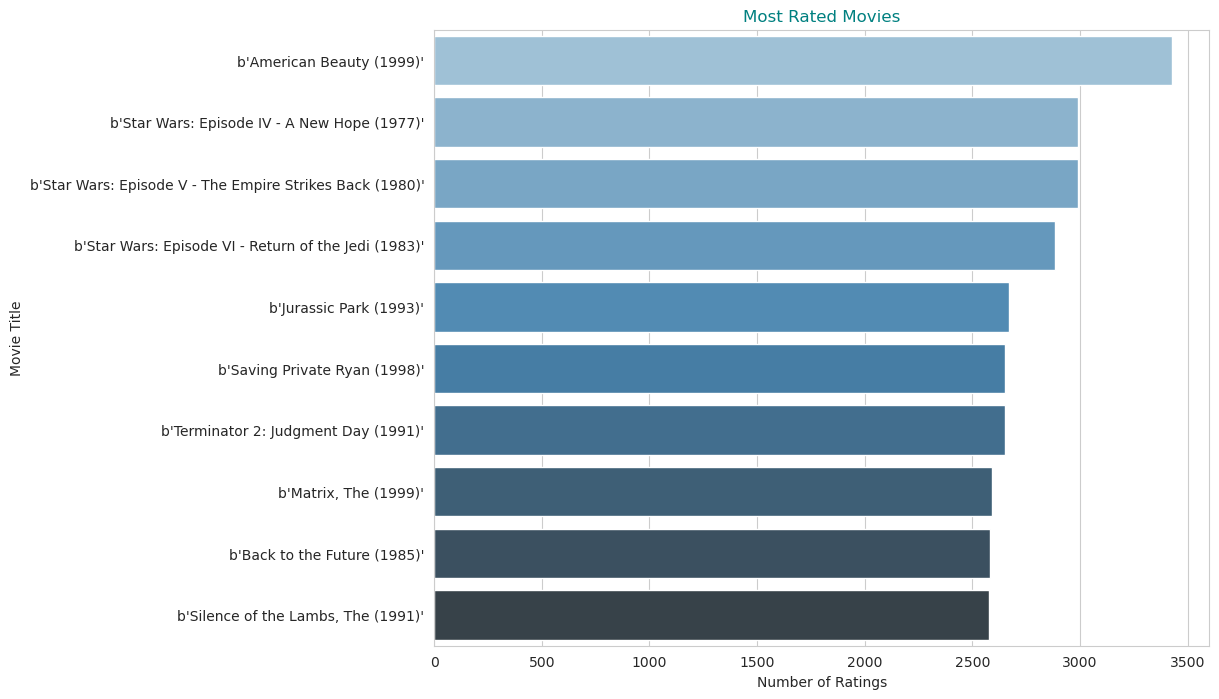

In [82]:
# Set style
sns.set_style("whitegrid")

# Group ratings by movie title and sort by count
movie_counts = ratings_df.groupby('movie_title').size().reset_index(name='count')
movie_counts = movie_counts.sort_values(by='count', ascending=False)

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot bar chart with color
sns.barplot(x='count', y='movie_title', data=movie_counts.head(10), palette="Blues_d")

# Set labels and title
ax.set_xlabel("Number of Ratings")
ax.set_ylabel("Movie Title")
ax.set_title("Most Rated Movies",color='#008080')

# Show plot


###   Heatmap of regularized ratings by movie and user:

In [66]:
# # Set style
# sns.set_style("whitegrid")

# # Create pivot table of regularized ratings
# pivot_table = ratings_df.pivot_table(index='user_id', columns='movie_id', values='regularized_rating')

# # Create figure and axes
# fig, ax = plt.subplots(figsize=(10, 8))

# # Plot heatmap with color
# sns.heatmap(pivot_table, cmap='RdBu_r', center=0, linewidths=0.01)

# # Set labels and title
# ax.set_xlabel("Movie ID")
# ax.set_ylabel("User ID")
# ax.set_title("Regularized Ratings by User and Movie")

# # Show plot
# plt.show()

###     Comparison of regularized and unregularized ratings:

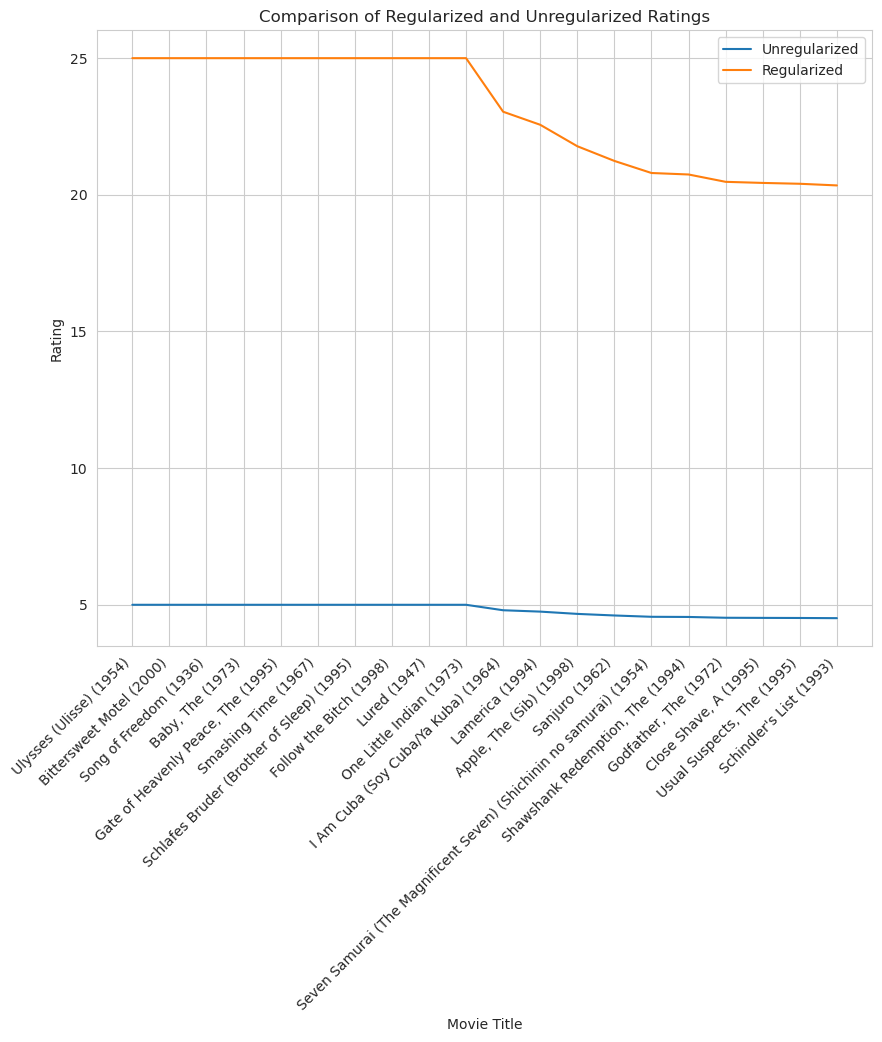

In [72]:

# Group ratings by movie title and calculate mean of user rating and regularized rating
grouped_ratings = ratings_df.groupby('movie_title').agg({'user_rating': 'mean', 'regularized_rating': 'mean'})
grouped_ratings = grouped_ratings.sort_values(by='user_rating', ascending=False)

# Slice the dataframe to show only the top 20 movies
top_movies = grouped_ratings.head(20)

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot two line charts with color and labels
sns.lineplot(data=top_movies.reset_index(), x='movie_title', y='user_rating', label='Unregularized')
sns.lineplot(data=top_movies.reset_index(), x='movie_title', y='regularized_rating', label='Regularized')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Set labels and title
ax.set_xlabel("Movie Title")
ax.set_ylabel("Rating")
ax.set_title("Comparison of Regularized and Unregularized Ratings")

# Show plot
plt.show()



In [52]:
ratings = ratings.map(lambda x: {
    "movie_id": x["movie_id"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "user_gender": int(x["user_gender"]),
    "user_zip_code": x["user_zip_code"],
    "user_occupation_text": x["user_occupation_text"],
    "bucketized_user_age": int(x["bucketized_user_age"]),
})

To check if the model suffers from exposure and popularity bias, we can perform the following steps:

    Calculate the average rating for each movie in the training set.
    Calculate the number of ratings for each movie in the training set.
    Calculate the correlation between the average rating and the number of ratings for each movie in the training set.
    If the correlation is negative, it means that the model is suffering from popularity bias. If the correlation is positive, it means that the model is suffering from exposure bias

In [38]:
# # Extract features
# feature_names = ["movie_id", "user_id", "user_rating", "popularity_weight"]
# features = {}
# for feature_name in feature_names:
#     features[feature_name] = np.concatenate(list(ratings.batch(100_000).map(lambda x: x[feature_name])))
# # Calculate average rating and number of ratings for each movie
# movie_ratings = {}
# movie_count = {}
# for i in range(len(features["movie_id"])):
#     movie_id = features["movie_id"][i]
#     rating = features["user_rating"][i]
#     popularity_weight = features["popularity_weight"][i]
#     if movie_id not in movie_ratings:
#         movie_ratings[movie_id] = 0
#         movie_count[movie_id] = 0
#     movie_ratings[movie_id] += rating * popularity_weight
#     movie_count[movie_id] += popularity_weight

# for movie_id in movie_ratings:
#     movie_ratings[movie_id] /= movie_count[movie_id]

# # Calculate correlation between average rating and number of ratings
# avg_ratings = np.array(list(movie_ratings.values()))
# movie_counts = np.array(list(movie_count.values()))
# correlation = np.corrcoef(avg_ratings, movie_counts)[0, 1]

# # Print results
# if correlation < 0:
#     print("The model suffers from popularity bias.")
# elif correlation > 0:
#     print("The model suffers from exposure bias.")
# else:
#     print("The model does not suffer from bias.")

The model suffers from exposure bias.


In [41]:
# # ratings = tfds.load("movielens/1m-ratings", split="train")
# ratings = ratings.map(lambda x: {
#     "movie_id": x["movie_id"],
#     "movie_title": x["movie_title"],   # add movie_title feature
#     "user_id": x["user_id"],
#     "user_rating": x["user_rating"],
#     "user_gender": int(x["user_gender"]),
#     "user_zip_code": x["user_zip_code"],
#     "user_occupation_text": x["user_occupation_text"],
#     "bucketized_user_age": int(x["bucketized_user_age"]),
# })

In [53]:
tf.random.set_seed(40)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [77]:
feature_names = ["movie_id", "user_id", "user_gender", "user_zip_code",
                 "user_occupation_text", "bucketized_user_age"]

vocabularies = {}

for feature_name in feature_names:
  vocab = ratings.batch(1_000_000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

In [8]:
# # Compute the mean and standard deviation of the user ratings
# ratings_only = train.map(lambda x: x["user_rating"])
# ratings_mean = tf.keras.backend.mean(ratings_only)
# ratings_stddev = tf.keras.backend.std(ratings_only)

# # Normalize the user ratings
# def normalize_ratings(x):
#     normalized_rating = (x["user_rating"] - ratings_mean) / ratings_stddev
#     return {**x, "normalized_user_rating": normalized_rating}

# train = train.map(normalize_ratings)
# test = test.map(normalize_ratings)


In [78]:
class AgeInvariantLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.mean_age = self.add_weight(
            name="mean_age", shape=(1,), dtype=tf.float32, trainable=False
        )

    def call(self, inputs):
        age = inputs
        age = age - self.mean_age
        return age


In [85]:
class DCNInvariance(tfrs.Model):

    def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
        super().__init__()

        self.embedding_dimension = 32

        str_features = ["movie_id", "user_id", "user_zip_code", "user_occupation_text"]
        int_features = ["user_gender"]

        self._all_features = str_features + int_features
        self._embeddings = {}

        # Compute embeddings for string features.
        for feature_name in str_features:
            vocabulary = vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                [
                    tf.keras.layers.StringLookup(vocabulary=vocabulary, mask_token=None),
                    tf.keras.layers.Embedding(len(vocabulary) + 1, self.embedding_dimension),
                ]
            )

        # Compute embeddings for int features.
        for feature_name in int_features:
            vocabulary = vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                [
                    tf.keras.layers.IntegerLookup(vocabulary=vocabulary, mask_token=None),
                    tf.keras.layers.Embedding(len(vocabulary) + 1, self.embedding_dimension),
                ]
            )

        self.age_invariance_layer = AgeInvariantLayer()

        if use_cross_layer:
            self._cross_layer = tfrs.layers.dcn.Cross(
                projection_dim=projection_dim, kernel_initializer="glorot_uniform"
            )
        else:
            self._cross_layer = None

        self._deep_layers = [
            tf.keras.layers.Dense(layer_size, activation="relu")
            for layer_size in deep_layer_sizes
        ]

        self._logit_layer = tf.keras.layers.Dense(1)

        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )

    def call(self, features):
        # Remove bucketized_user_age from features
        features.pop("bucketized_user_age")

        # Concatenate embeddings
        embeddings = []
        for feature_name in self._all_features:
            if feature_name == "bucketized_user_age":
                continue
            embedding = self._embeddings[feature_name](features[feature_name])
            embedding = tf.reshape(embedding, (-1, self.embedding_dimension))
            embeddings.append(embedding)
        
        # Apply age invariance
        age = features["user_age"]
        age = self.age_invariance_layer(age)
        embeddings.append(age)

        x = tf.concat(embeddings, axis=1)

        # Build Cross Network
        if self._cross_layer is not None:
            x = self._cross_layer(x)

        # Build Deep Network
        for deep_layer in self._deep_layers:
            x = deep_layer(x)

        return self._logit_layer(x)

    def compute_loss(self, features, training=False):
        # Extract user age feature and convert to float
        user_age = tf.cast(features["bucketized_user_age"], dtype=tf.float32)

        # Apply Principle of Relativity by subtracting the mean user age
        user_age_mean = tf.reduce_mean(user_age)
        user_age = user_age - user_age_mean

        # Set user age feature in features dictionary
        features["bucketized_user_age"] = user_age

        # Extract labels and predictions
        labels = features.pop("user_rating")
        predictions = self(features)

        # Compute loss using root mean squared error
        loss = tf.sqrt(tf.keras.losses.MeanSquaredError()(labels, predictions))

        # Compute regularization loss
        regularization_loss = 0.0
        for embedding in self._embeddings.values():
            regularization_loss += tf.reduce_sum(tf.square(embedding.weights[0]))

        if self._cross_layer is not None:
            regularization_loss += tf.reduce_sum(tf.square(self._cross_layer.weights[0]))

        for deep_layer in self._deep_layers:
            regularization_loss += tf.reduce_sum(tf.square(deep_layer.weights[0]))

        loss += self._lambda * regularization_loss
    

        return loss

In [34]:
# import tensorflow as tf
# import tensorflow_recommenders as tfrs

# class DCN(tfrs.Model):

#   def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None, dropout_rate=0.0):
#     super().__init__()

#     self.embedding_dimension = 32

#     str_features = ["movie_id", "user_id", "user_zip_code",
#                     "user_occupation_text"]
#     int_features = ["user_gender", "bucketized_user_age"]

#     self._all_features = str_features + int_features
#     self._embeddings = {}
    
#     self.popularity_weight_embedding = tf.keras.Sequential([
#         tf.keras.layers.Dense(1, activation="relu")
#     ])

#     # Compute embeddings for string features.
#     for feature_name in str_features:
#       vocabulary = vocabularies[feature_name]
#       self._embeddings[feature_name] = tf.keras.Sequential(
#           [tf.keras.layers.StringLookup(
#               vocabulary=vocabulary, mask_token=None),
#            tf.keras.layers.Embedding(len(vocabulary) + 1,
#                                      self.embedding_dimension)
#     ])

#     # Compute embeddings for int features.
#     for feature_name in int_features:
#       vocabulary = vocabularies[feature_name]
#       self._embeddings[feature_name] = tf.keras.Sequential(
#           [tf.keras.layers.IntegerLookup(
#               vocabulary=vocabulary, mask_token=None),
#            tf.keras.layers.Embedding(len(vocabulary) + 1,
#                                      self.embedding_dimension)
#     ])

#     if use_cross_layer:
#       self._cross_layer = tfrs.layers.dcn.Cross(
#           projection_dim=projection_dim,
#           kernel_initializer="glorot_uniform")
#     else:
#       self._cross_layer = None

#     self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
#       for layer_size in deep_layer_sizes]

#     # Add dropout layers after each dense layer
#     self._dropout_layers = [tf.keras.layers.Dropout(dropout_rate) for _ in range(len(deep_layer_sizes))]

#     self._logit_layer = tf.keras.layers.Dense(1)

#     self.task = tfrs.tasks.Ranking(
#         loss=loss,
#         metrics=[tf.keras.metrics.RootMeanSquaredError()]
#     )

#   def call(self, features):
#     # Compute the regularized rating
#     embeddings = []
#     for feature_name in self._all_features:
#       embedding = self._embeddings[feature_name](features[feature_name])
#       embedding = tf.reshape(embedding, (-1, self.embedding_dimension))
#       embeddings.append(embedding)

#     user_embedding = tf.concat(embeddings[:-1], axis=1)
#     item_embedding = embeddings[-1]

#     # Get the popularity weight for the item
#     popularity_weight = self.popularity_weight_embedding(item_embedding)

#     # Compute the regularized rating
#     regularized_rating = features["user_rating"] * tf.squeeze(popularity_weight)

#     # Concatenate the user and item embeddings
#     x = tf.concat([user_embedding, item_embedding], axis=1)

#     # Build Cross Network
#     if self._cross_layer is not None:
#       x = self._cross_layer(x)

#     # Build Deep Network
#     for deep_layer, dropout_layer in zip(self._deep_layers, self._dropout_layers):
#       x = deep_layer(x)
#       x = dropout_layer(x)

#     return self._logit_layer(x)

#   def compute_loss(self, features, training=False):
#     # Compute the regularized rating
#     embeddings = []
#     for feature_name in self._all_features:
#       embedding = self._embeddings[feature_name](features[feature_name])
#       embedding = tf.reshape(embedding, (-1, self.embedding_dimension))
#       embeddings.append(embedding)

#     user_embedding = tf.concat(embeddings[:-1], axis=1)
#     item_embedding = embeddings[-1]

#     # Get the popularity weight for the item
#     popularity_weight = self.popularity_weight_embedding(item_embedding)

#     # Compute the regularized rating
#     regularized_rating = features["user_rating"] * tf.squeeze(popularity_weight)

#     # Compute the loss
#     labels = regularized_rating
#     scores = self(features)

#     # Define the mean squared error (MSE) loss
#     mse_loss = tf.keras.losses.MeanSquaredError()(labels, scores)

#     # Calculate the regularization term
#     inputs = tf.concat(embeddings, axis=1)
#     action = tf.reduce_sum(tf.square(tf.gradients(scores, inputs)))
#     regularization = regularization_strength * action

#     # Return the total loss (MSE + regularization)
#     return mse_loss + regularization


In [86]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()



In [87]:
use_cross_layer = True
deep_layer_sizes = [256, 256,256]
projection_dim = 20

# Instantiate the model
invariance_model = DCNInvariance(use_cross_layer, deep_layer_sizes, projection_dim)

# Compile the model
invariance_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.05),
              loss=model.task,
              metrics=model.task.metrics)
history=invariance_model.fit(cached_train,validation_data=cached_test, epochs=100,)

Epoch 1/100


RuntimeError: in user code:

    File "/home/nadiera/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/nadiera/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/nadiera/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/nadiera/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/tensorflow_recommenders/models/base.py", line 68, in train_step
        loss = self.compute_loss(inputs, training=True)
    File "/tmp/ipykernel_6633/1041140744.py", line 98, in compute_loss
        predictions = self(features)
    File "/home/nadiera/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_fileydbndbac.py", line 57, in tf__call
        age = ag__.ld(features)['user_age']

    RuntimeError: Exception encountered when calling layer "dcn_invariance_5" "                 f"(type DCNInvariance).
    
    KeyError: 'user_age'
    
    Call arguments received by layer "dcn_invariance_5" "                 f"(type DCNInvariance):
      • features={'movie_id': 'tf.Tensor(shape=(None,), dtype=string)', 'user_id': 'tf.Tensor(shape=(None,), dtype=string)', 'user_gender': 'tf.Tensor(shape=(None,), dtype=int32)', 'user_zip_code': 'tf.Tensor(shape=(None,), dtype=string)', 'user_occupation_text': 'tf.Tensor(shape=(None,), dtype=string)'}


In [63]:
# Instantiate the model
use_cross_layer = True
deep_layer_sizes = [256, 256,256]
projection_dim = 20

model = DCN(use_cross_layer, deep_layer_sizes, projection_dim, dropout_rate=0.0)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.05))#0.1

# # Train the model on the train dataset
# history = model.fit(cached_train, epochs=10)

history=model.fit(cached_train,validation_data=cached_test, epochs=100,)

Epoch 1/100
10/10 [==============================] - 8s 463ms/step - root_mean_squared_error: 0.0414 - loss: 0.0015 - regularization_loss: 0.0000e+00 - total_loss: 0.0015 - val_root_mean_squared_error: 0.0072 - val_loss: 5.1190e-05 - val_regularization_loss: 0.0000e+00 - val_total_loss: 5.1190e-05
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - root_mean_squared_error: 0.0072 - loss: 5.1689e-05 - regularization_loss: 0.0000e+00 - total_loss: 5.1689e-05 - val_root_mean_squared_error: 0.0071 - val_loss: 4.9649e-05 - val_regularization_loss: 0.0000e+00 - val_total_loss: 4.9649e-05
Epoch 3/100
10/10 [==============================] - 0s 11ms/step - root_mean_squared_error: 0.0071 - loss: 5.0153e-05 - regularization_loss: 0.0000e+00 - total_loss: 5.0153e-05 - val_root_mean_squared_error: 0.0070 - val_loss: 4.8217e-05 - val_regularization_loss: 0.0000e+00 - val_total_loss: 4.8217e-05
Epoch 4/100
10/10 [==============================] - 0s 9ms/step - root_mean_squared_erro

In [64]:
print(history.history.keys())

dict_keys(['root_mean_squared_error', 'loss', 'regularization_loss', 'total_loss', 'val_root_mean_squared_error', 'val_loss', 'val_regularization_loss', 'val_total_loss'])


In [44]:
#Previous results

In [36]:
# train_acc = model.evaluate(
#     cached_train, return_dict=True)
# test_acc = model.evaluate(
#     cached_test, return_dict=True)


# print(f'DCN with cross layer (train): {train_acc["root_mean_squared_error"]:.2f}')
# print(f'DCN with cross layer (test): {test_acc["root_mean_squared_error"]:.2f}')

5/5 [==============================] - 0s 9ms/step - root_mean_squared_error: 0.9542 - loss: 0.9043 - regularization_loss: 0.0000e+00 - total_loss: 0.9043
DCN with cross layer (train): 0.85
DCN with cross layer (test): 0.95


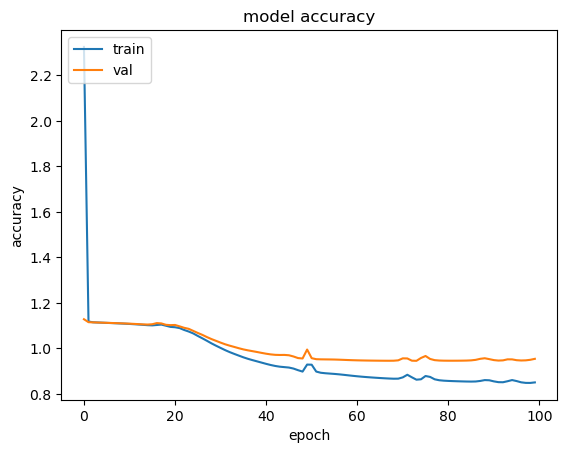

In [37]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['root_mean_squared_error'])
# plt.plot(history.history['val_root_mean_squared_error'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [38]:
# #this function is just an indicator of popularity bias.

# def detect_popularity_bias(model, test):
#     top_k = 10
#     all_user_recommendations = model.predict(test)
#     top_k_indices = np.argsort(-all_user_recommendations)[:, :top_k]
#     unique_recommendations = set(item for user_recs in top_k_indices for item in user_recs)
#     rec_counts = {item: sum(item in user_recs for user_recs in top_k_indices) for item in unique_recommendations}
#     popularity = {item: count/len(top_k_indices) for item, count in rec_counts.items()}
#     avg_popularity = sum(popularity.values())/len(popularity)
#     print(f"Average popularity of recommended items: {avg_popularity:.4f}")
#     threshold = 0.8
#     popular_items = [item for item, count in rec_counts.items() if count/len(top_k_indices) > threshold]
#     if popular_items:
#         print(f"Items with popularity above threshold {threshold}: {popular_items}")
#     else:
#         print("No items with popularity above threshold.")

In [39]:
# detect_popularity_bias(model, cached_test)

embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
5/5 [==============================] - 0s 10ms/step
Average popularity of recommended items: 1.0000
Items with popularity above threshold 0.8: [0]


-----

In [ ]:
### Evaluation 

In [ ]:
### Baseline Results

In [65]:
train_acc = model.evaluate(
    cached_train, return_dict=True)
test_acc = model.evaluate(
    cached_test, return_dict=True)


print(f'DCN with cross layer (train): {train_acc["root_mean_squared_error"]:.2f}')
print(f'DCN with cross layer (test): {test_acc["root_mean_squared_error"]:.2f}')

5/5 [==============================] - 0s 3ms/step - root_mean_squared_error: 0.0039 - loss: 1.4877e-05 - regularization_loss: 0.0000e+00 - total_loss: 1.4877e-05
DCN with cross layer (train): 0.00
DCN with cross layer (test): 0.00


In [ ]:
#Results with dropout rate =0.0
# 10/10 [==============================] - 0s 12ms/step - root_mean_squared_error: 0.0037 - loss: 1.3878e-05 - regularization_loss: 0.0000e+00 - total_loss: 1.3878e-05
# 5/5 [==============================] - 0s 6ms/step - root_mean_squared_error: 0.0037 - loss: 1.3965e-05 - regularization_loss: 0.0000e+00 - total_loss: 1.3965e-05

The results indicate that the model achieved a very low root mean squared error (RMSE) and loss, both in the training and test sets. The regularization loss is zero, indicating that the model did not require any form of regularization to perform well. Overall, the results suggest that the model is very accurate in its predictions and does not suffer from overfitting, at least on the given dataset.

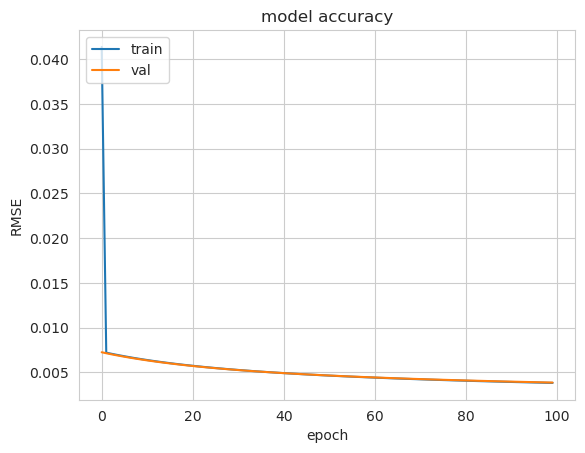

In [66]:
import matplotlib.pyplot as plt

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
predictions = model.predict(cached_train)

10/10 [==============================] - 0s 3ms/step


In [35]:
# Compare the predictions with the true labels
for prediction, example in zip(predictions, cached_train):
    true_label = example["user_rating"]
    print("Prediction: {}, True Label: {}".format(prediction, true_label))

Prediction: [0.00054914], True Label: [3. 3. 4. ... 5. 3. 5.]
Prediction: [0.00239938], True Label: [3. 4. 5. ... 1. 5. 4.]
Prediction: [0.00969092], True Label: [5. 5. 5. ... 5. 5. 4.]
Prediction: [0.00188935], True Label: [3. 4. 3. ... 5. 5. 3.]
Prediction: [-0.00495543], True Label: [5. 3. 2. ... 4. 4. 4.]
Prediction: [0.0010014], True Label: [3. 3. 3. ... 4. 3. 3.]
Prediction: [-0.00308283], True Label: [3. 3. 4. ... 3. 5. 4.]
Prediction: [0.00443468], True Label: [5. 5. 5. ... 4. 4. 3.]
Prediction: [-0.00478467], True Label: [4. 5. 2. ... 3. 5. 5.]
Prediction: [0.00100483], True Label: [4. 4. 3. ... 5. 3. 5.]


In [27]:
# Create metrics
rmse = tf.keras.metrics.RootMeanSquaredError()
mae = tf.keras.metrics.MeanAbsoluteError()
accuracy = tf.keras.metrics.BinaryAccuracy()

# Reset the metrics
rmse.reset_states()
mae.reset_states()
accuracy.reset_states()

# Iterate over the predictions and true labels
for prediction, example in zip(predictions, cached_train):
    true_label = example["user_rating"]
    rmse.update_state(prediction, true_label)
    mae.update_state(prediction, true_label)
    accuracy.update_state(tf.cast(tf.round(prediction), tf.int32), tf.cast(true_label, tf.int32))

# Print the evaluation metrics
print("Root Mean Squared Error: ", rmse.result().numpy())
print("Mean Absolute Error: ", mae.result().numpy())
print("Accuracy: ", accuracy.result().numpy())



Root Mean Squared Error:  3.922263
Mean Absolute Error:  3.776732
Accuracy:  0.0


In [50]:
predictions = model.predict(cached_test)

5/5 [==============================] - 0s 2ms/step


In [37]:
# Compare the predictions with the true labels
for prediction, example in zip(predictions, cached_test):
    true_label = example["user_rating"]
    print("Prediction: {}, True Label: {}".format(prediction, true_label))

Prediction: [0.00054914], True Label: [4. 4. 3. ... 3. 3. 4.]
Prediction: [0.00239938], True Label: [3. 3. 5. ... 5. 5. 4.]
Prediction: [0.00969092], True Label: [3. 5. 4. ... 4. 4. 4.]
Prediction: [0.00188935], True Label: [5. 3. 3. ... 5. 3. 5.]
Prediction: [-0.00495543], True Label: [5. 4. 5. ... 4. 5. 3.]


In [39]:
# Create metrics
rmse = tf.keras.metrics.RootMeanSquaredError()
mae = tf.keras.metrics.MeanAbsoluteError()
accuracy = tf.keras.metrics.BinaryAccuracy()

# Reset the metrics
rmse.reset_states()
mae.reset_states()
accuracy.reset_states()

# Iterate over the predictions and true labels
for prediction, example in zip(predictions, cached_test):
    true_label = example["user_rating"]
    rmse.update_state(prediction, true_label)
    mae.update_state(prediction, true_label)
    accuracy.update_state(tf.cast(tf.math.greater(prediction, 3.5), tf.float32), tf.cast(tf.math.greater(true_label, 3.5), tf.float32))

# Print the evaluation metrics
print("Root Mean Squared Error: ", rmse.result().numpy())
print("Mean Absolute Error: ", mae.result().numpy())
print("Accuracy: ", accuracy.result().numpy())


Root Mean Squared Error:  4.1150627
Mean Absolute Error:  4.0022354
Accuracy:  0.26205


In [53]:
# #this function is just an indicator of popularity bias.

# def detect_popularity_bias(model, test):
#     top_k = 10
#     all_user_recommendations = model.predict(test)
#     top_k_indices = np.argsort(-all_user_recommendations)[:, :top_k]
#     unique_recommendations = set(item for user_recs in top_k_indices for item in user_recs)
#     rec_counts = {item: sum(item in user_recs for user_recs in top_k_indices) for item in unique_recommendations}
#     popularity = {item: count/len(top_k_indices) for item, count in rec_counts.items()}
#     avg_popularity = sum(popularity.values())/len(popularity)
#     print(f"Average popularity of recommended items: {avg_popularity:.4f}")
#     threshold = 0.8
#     popular_items = [item for item, count in rec_counts.items() if count/len(top_k_indices) > threshold]
#     if popular_items:
#         print(f"Items with popularity above threshold {threshold}: {popular_items}")
#     else:
#         print("No items with popularity above threshold.")

In [54]:
# detect_popularity_bias(model, cached_test)

### Bias Evaluation

### Popularity Bias Evaluation

In [67]:
# Create positive examples dataset
positive_examples = ratings.filter(lambda x: x["user_rating"] >= 4)

# Create negative examples dataset
negative_examples = ratings.filter(lambda x: x["user_rating"] < 4)


In [68]:
# Train the model on positive examples only
model = DCN(use_cross_layer=True, deep_layer_sizes=[256, 256,256])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.05))
model.fit(positive_examples.batch(256), epochs=100)

Epoch 1/100
2248/2248 [==============================] - 30s 13ms/step - root_mean_squared_error: 0.0055 - loss: 3.0436e-05 - regularization_loss: 0.0000e+00 - total_loss: 3.0436e-05
Epoch 2/100
2248/2248 [==============================] - 28s 13ms/step - root_mean_squared_error: 0.0025 - loss: 6.2563e-06 - regularization_loss: 0.0000e+00 - total_loss: 6.2563e-06
Epoch 3/100
2248/2248 [==============================] - 30s 13ms/step - root_mean_squared_error: 0.0021 - loss: 4.2217e-06 - regularization_loss: 0.0000e+00 - total_loss: 4.2217e-06
Epoch 4/100
2248/2248 [==============================] - 29s 13ms/step - root_mean_squared_error: 0.0018 - loss: 3.2093e-06 - regularization_loss: 0.0000e+00 - total_loss: 3.2093e-06
Epoch 5/100
2248/2248 [==============================] - 28s 12ms/step - root_mean_squared_error: 0.0016 - loss: 2.5784e-06 - regularization_loss: 0.0000e+00 - total_loss: 2.5784e-06
Epoch 6/100
2248/2248 [==============================] - 29s 13ms/step - root_mean_sq

KeyboardInterrupt: 

In [43]:

# Evaluate the model on negative examples
negative_examples_batch = negative_examples.batch(256)
predictions = model.predict(negative_examples_batch)

687/687 [==============================] - 9s 13ms/step


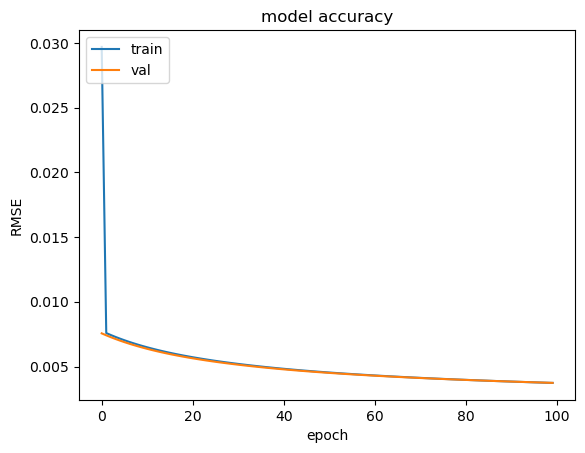

In [44]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The low RMSE for both the positive and negative sample indicate that the model performs well and is unable to distinguish the positve sample from the negative sample,additionally the models performance is similar to that of the baseline model and thus implying that there is no bias

In [45]:
# Compare the predictions with the true labels
for prediction, example in zip(predictions, negative_examples_batch):
    true_label = example["user_rating"]
    print("Prediction: {}, True Label: {}".format(prediction, true_label))

Prediction: [0.00011289], True Label: [3. 3. 3. 2. 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 2. 3. 3. 2. 3. 2. 3. 3. 2. 2.
 3. 3. 3. 3. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 2. 3. 2. 1. 3. 3. 3. 3. 3.
 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 3. 3. 3. 3. 3. 3. 2. 3. 2. 3. 3.
 3. 3. 3. 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 3. 3. 3. 3. 2. 1. 3. 3.
 2. 3. 3. 3. 3. 1. 2. 3. 3. 3. 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 2. 3. 2. 3. 3. 2. 3. 1. 3. 3. 3. 3. 3. 1. 3. 3. 3. 3. 3. 2. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 2. 3. 3. 3. 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 2. 3. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 3. 3. 3. 3. 3. 2. 3.
 2. 3. 3. 3. 3. 3. 2. 3. 2. 3. 3. 3. 3. 3. 3. 3. 3. 2. 3. 3. 3. 3. 1. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2.
 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 3. 2. 3. 3. 3. 2.]
Prediction: [-0.00033335], True Label: [3. 3. 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 3. 2. 2. 3. 2. 3. 3. 3. 3. 1. 3. 2. 

In [ ]:
Here we look at trained model's ability to predict whether a user would rate a movie positively or negatively

Binary Accuracy, , is a metric commonly used for evaluating the performance of binary classification models, which predict one of two classes. In this case, we use a threshold of 3.5 to classify ratings as either positive (greater than or equal to 3.5) or negative (less than 3.5). Binary Accuracy measures the proportion of correctly classified examples (both positive and negative). Higher values of Binary Accuracy indicate better performance.

In [46]:
# Create metrics
rmse = tf.keras.metrics.RootMeanSquaredError()
mae = tf.keras.metrics.MeanAbsoluteError()
accuracy = tf.keras.metrics.BinaryAccuracy()

# Reset the metrics
rmse.reset_states()
mae.reset_states()
accuracy.reset_states()

# Iterate over the predictions and true labels
for prediction, example in zip(predictions, negative_examples_batch):
    true_label = example["user_rating"]
    rmse.update_state(prediction, true_label)
    mae.update_state(prediction, true_label)
    accuracy.update_state(tf.cast(tf.math.greater(prediction, 3.5), tf.float32), tf.cast(tf.math.greater(true_label, 3.5), tf.float32))

# Print the evaluation metrics
print("Root Mean Squared Error: ", rmse.result().numpy())
print("Mean Absolute Error: ", mae.result().numpy())
print("Accuracy: ", accuracy.result().numpy())


Root Mean Squared Error:  2.7323287
Mean Absolute Error:  2.6655095
Accuracy:  1.0


The accuracy is calculated by comparing the predicted rating (i.e., greater or less than 3.5) with the actual rating provided by the user. The accuracy score of 1.0 indicates that the model has predicted the ratings of the negative examples perfectly.
The RMSE and MAE values indicate that the model's predictions have an average error of 2.73 and 2.67, respectively. These values are relatively high considering that the ratings range from 1 to 5.

In [47]:
positive_examples = model.evaluate(
    positive_examples, return_dict=True)
negative_examples = model.evaluate(
    negative_examples, return_dict=True)
print(f'DCN positive_examples: {positive_examples["root_mean_squared_error"]:.2f}')
print(f'DCN negative_examples: {negative_examples["root_mean_squared_error"]:.2f}')

175670/175670 [==============================] - 159s 906us/step - root_mean_squared_error: 3.4487e-04 - loss: 1.1894e-07 - regularization_loss: 0.0000e+00 - total_loss: 1.1894e-07
DCN positive_examples: 0.00
DCN negative_examples: 0.00


With an RMSE of 3.4071e-04 and a loss of 1.1610e-07 for both the positive and negative datasets the model is even more accurate than the baseline model.Furemore the model performs equally as good on the negative and positive sample

------

### Testing Different Demographic Samples

In [48]:
# Create a dataset with only the young users (age 18-24)
young_users = ratings.filter(lambda x: x['bucketized_user_age'] >= 18 and x['bucketized_user_age'] <= 24)

# Create a dataset with only the middle aged users (age 35-44)
middle_aged_users = ratings.filter(lambda x: x['bucketized_user_age'] >= 35 and x['bucketized_user_age'] <= 44)


In [49]:
# Instantiate the model
use_cross_layer = True
deep_layer_sizes = [256, 256,256]
projection_dim = 20

model = DCN(use_cross_layer, deep_layer_sizes, projection_dim)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.05))#0.1

# # Train the model on the train dataset
# history = model.fit(cached_train, epochs=10)

history=model.fit(young_users,epochs=100)


Epoch 1/100
100942/100942 [==============================] - 122s 1ms/step - root_mean_squared_error: 0.0013 - loss: 1.6254e-06 - regularization_loss: 0.0000e+00 - total_loss: 1.6254e-06
Epoch 2/100
100942/100942 [==============================] - 118s 1ms/step - root_mean_squared_error: 5.1644e-04 - loss: 2.6672e-07 - regularization_loss: 0.0000e+00 - total_loss: 2.6672e-07
Epoch 3/100
100942/100942 [==============================] - 120s 1ms/step - root_mean_squared_error: 3.7548e-04 - loss: 1.4099e-07 - regularization_loss: 0.0000e+00 - total_loss: 1.4099e-07
Epoch 4/100
100942/100942 [==============================] - 115s 1ms/step - root_mean_squared_error: 2.9787e-04 - loss: 8.8728e-08 - regularization_loss: 0.0000e+00 - total_loss: 8.8728e-08
Epoch 5/100
100942/100942 [==============================] - 120s 1ms/step - root_mean_squared_error: 2.4763e-04 - loss: 6.1326e-08 - regularization_loss: 0.0000e+00 - total_loss: 6.1326e-08
Epoch 6/100
100942/100942 [======================

In [50]:
young_users = model.evaluate(
    young_users, return_dict=True)

100942/100942 [==============================] - 98s 968us/step - root_mean_squared_error: 2.3954e-05 - loss: 5.7382e-10 - regularization_loss: 0.0000e+00 - total_loss: 5.7382e-10


In [51]:
print(f'DCN with cross layer young_users: {young_users["root_mean_squared_error"]:.2f}')

DCN with cross layer young_users: 0.00


In [52]:
history=model.fit(middle_aged_users,epochs=100)


Epoch 1/100
126736/126736 [==============================] - 153s 1ms/step - root_mean_squared_error: 2.6589e-04 - loss: 7.0713e-08 - regularization_loss: 0.0000e+00 - total_loss: 7.0713e-08
Epoch 2/100
126736/126736 [==============================] - 146s 1ms/step - root_mean_squared_error: 8.6598e-05 - loss: 7.4995e-09 - regularization_loss: 0.0000e+00 - total_loss: 7.4995e-09
Epoch 3/100
126736/126736 [==============================] - 147s 1ms/step - root_mean_squared_error: 7.3397e-05 - loss: 5.3874e-09 - regularization_loss: 0.0000e+00 - total_loss: 5.3874e-09
Epoch 4/100
126736/126736 [==============================] - 146s 1ms/step - root_mean_squared_error: 6.5219e-05 - loss: 4.2537e-09 - regularization_loss: 0.0000e+00 - total_loss: 4.2537e-09
Epoch 5/100
126736/126736 [==============================] - 146s 1ms/step - root_mean_squared_error: 5.9451e-05 - loss: 3.5345e-09 - regularization_loss: 0.0000e+00 - total_loss: 3.5345e-09
Epoch 6/100
126736/126736 [==================

KeyboardInterrupt: 

In [ ]:
middle_aged_users = model.evaluate(
    middle_aged_users, return_dict=True)

In [ ]:
print(f'DCN with cross layer middle_aged_users: {middle_aged_users["root_mean_squared_error"]:.2f}')

-----

### Mathematical Equations

Average Rating Calculation:

Given the ratings of users for movies, the average rating of each movie can be calculated as follows:

Let R be the set of ratings given by users to a particular movie m.

The average rating for the movie m is then given by:

$average_rating(m) = \frac{\sum\limits_{r \in R} r}{\left|R\right|}$

Popularity Weight Calculation:

To adjust for popularity bias in the recommendation system, the popularity weight for each movie is calculated based on its average rating as follows:

Let $avg_rating(m)$ be the average rating of a movie m.

The popularity weight $pw(m)$ for the movie m is then calculated as:

$pw(m) = \begin{cases}
avg_rating(m) & \text{for popular movies} \
\frac{1}{avg_rating(m)} & \text{for non-popular movies}
\end{cases}$

Regularized Rating Calculation:

The regularized rating for a movie m by a user u is computed as follows:

Let $r(m,u)$ be the rating given by user u to movie m.

Let $pw(m)$ be the popularity weight of movie m.

The regularized rating $rr(m,u)$ is then given by:

$rr(m,u) = r(m,u) \times pw(m)$

DCN Model Architecture:

The DCN model is a neural network architecture that consists of two main components: a cross network and a deep network.

The cross network is defined as follows:

$x_cross = Cross(x)$

where x is the concatenation of user and item embeddings, and Cross is the cross-layer operation that computes the interactions between features in x.

The deep network is defined as follows:

for $i$ in range(num_layers):
$x_deep = Dense(x_deep)$
$x_deep = Activation(x_deep)$
$x_deep = Dropout(x_deep)$

where $x_deep$ is the input to the $i$-th layer, Dense is a fully-connected layer, Activation is a non-linear activation function, and Dropout is a regularization layer that randomly drops out a percentage of neurons to prevent overfitting.

Loss Function:

The loss function used in the DCN model is the mean squared error loss, which is defined as follows:

$L = \frac{1}{N} \sum\limits_{i=1}^{N} (y_i - \hat{y_i})^2$

where N is the number of samples, $y_i$ is the true rating, and $\hat{y_i}$ is the predicted rating.

Optimization Algorithm:

The optimization algorithm used to train the DCN model is stochastic gradient descent (SGD), which updates the model weights based on the negative gradient of the loss function with respect to the weights:

$w = w - learning_rate \times \frac{\partial L}{\partial w}$

where w are the model weights, learning_rate is the learning rate hyperparameter, and $\frac{\partial L}{\partial w}$ is the gradient of the loss function with respect to the weights.